# 1d2v-GEMPIC-Vlasov-Maxwell-Solver

## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import fembase as fem
import picbase as pic
from bsplines import Bspline
from scipy.integrate import fixed_quad
from scipy import integrate
from copy import deepcopy
import scipy as sc
import time

## Simulation parameters

In [2]:
# wavenumber of perturbations
k = 1.25

# boundaries and lenght of domain
a_boundary = 0
b_boundary = 2*np.pi/k
Lx = b_boundary - a_boundary

# number of elements and element boundaries
Nel = 32
el_b = np.linspace(a_boundary, b_boundary, Nel + 1)

# element size
dx = (b_boundary - a_boundary)/Nel

# degree of basis functions in V0
degree = 3

# degree and width of B-spline smoothing kernel
p = 3
Swidth = 8*Lx/(2*Nel)
dx_S = Swidth/(p + 1)


# number of particles for simulation
Np = np.int(1e5)

In [47]:
# time integrators for Hamiltonian splitting
def integrator_HE(b, v_x, v_y, dt):
    
    bnew = b - dt*np.dot(G, e)
    v_xnew = v_x + dt*q/m*S.transpose().dot(ex)
    v_ynew = v_y + dt*q/m*Q.transpose().dot(e)
    
    return bnew, v_xnew, v_ynew

def integrator_HB(e, b, dt):
    
    enew = e + dt*c**2*np.dot(mass_0_inv, np.dot(np.transpose(Grad), np.dot(mass_1, b)))
    
    return enew

def integrator_Hy(e, v_x, v_y, x_p, dt):
    
    enew = e - dt/eps0*q/m*np.dot(mass_0_inv, Q.dot(W.dot(v_y)))
    v_xnew = v_x + q/m*B.dot(v_y)
    
    return enew, v_xnew

def integrator_Hx(ex, x_p, v_x, v_y, dt, kernel_supp):
    
    x_pnew = (x_p + dt*v_x)%Lx
    print('end x_p = ', x_pnew)
    # new particle positions
    
    Ny = len(nodes)
    # number of spline boundaries
    
    Np = len(x_p)
    # particle number
    
    I_ip = sc.sparse.csr_matrix((len(ex), Np))    
    t_star = np.zeros((Ny, Np))
    t_vec = np.zeros((Ny, Np))
    
    t_large = Lx/np.tile(np.abs(v_x), (Ny, 1))
    
    
    for ii in range(len(x_vec)):
        
        y_vec = nodes + x_vec[ii]
        print('y_vec = ', y_vec)
        
        for iy in range(len(y_vec)):
            t_star[iy] = (y_vec[iy] - x_p)/v_x
            
        bol = t_star > 0
        
        t_vec[bol] = t_star[bol]
        t_vec[np.logical_not(bol)] = t_large[np.logical_not(bol)] + t_star[np.logical_not(bol)]
        print('t_vec = ', t_vec)
        # assemble t_vec which gives the times when the particles reach the nodes defining the smoothing kernel
        
        ind_t_min = np.argmin(t_vec, axis = 0)
        print('ind_t_min = ', ind_t_min)
        
        for pp in range(Np):
            t_lower = 0.
            t_upper = 0.
            
            for iy in range(len(y_vec)):
                
                if v_x[pp] > 0:
                    ind_now = (ind_t_min[pp] + iy)%len(y_vec)
                else:
                    ind_now = (ind_t_min[pp] - iy)%len(y_vec)
                    
                t_now = t_vec[ind_now, pp]
                print('t_now = ', t_now)
                
                integrand = lambda s : poly_list[ind_now - int(np.heaviside(v_x[pp], 1))](x_p[pp] 
                                                        - y_vec[ind_now - int(np.heaviside(v_x[pp], 1))] + s*v_x[pp])
                
                if t_now > dt:
                    if np.abs(x_p[pp] - x_vec[ii]) < kernel_supp/2:
                        t_upper = dt
                    else:
                        t_lower = t_now
                        print('t_lower/upper = ', t_lower, t_upper)
                        continue
                        
                else:
                    if np.abs(x_p[pp] - x_vec[ii]) > kernel_supp/2 and (iy == 0):
                        t_lower = t_now
                        print('t_lower/upper = ', t_lower, t_upper)
                        continue
                    else:
                        t_upper = t_now
                 
               
                print('t_lower/upper = ', t_lower, t_upper)
                
                I_ip[ii, pp] += fixed_quad(integrand, t_lower, t_upper)[0]
                print('I_ip = ', I_ip[ii, pp])
                      
                t_lower = t_now  
        
    return I_ip          

In [30]:
dS = 0.1
p = 3
poly_list, nodes = pic.spline_parts(p, dS)

0.04166666666666666
0.5
0.9583333333333333
0.9999999999999999


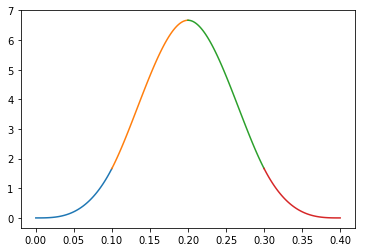

In [31]:
x_plot = np.linspace(0, dS, 100)
intgr = 0

for i in range(p + 1):
    plt.plot(x_plot + i*dS, poly_list[i](x_plot))
    intgr += fixed_quad(poly_list[i], 0, dS, n = np.ceil((p + 1)/2))[0]
    print(intgr)

In [32]:
nodes

array([-0.2, -0.1,  0. ,  0.1,  0.2])

In [56]:
# unit test for integrator_Hx
Lx = 2
x_p = np.array([0.5])
print('start x_p = ', x_p)

v_x = np.array([0.4])
print('v_x = ', v_x)

dt = 1
x_vec = np.array([1])

I_ip = integrator_Hx(np.array([1]), x_p, v_x, 1, dt, (p + 1)*dS)

start x_p =  [0.5]
v_x =  [0.4]
end x_p =  [0.9]
y_vec =  [0.8 0.9 1.  1.1 1.2]
t_vec =  [[0.75]
 [1.  ]
 [1.25]
 [1.5 ]
 [1.75]]
ind_t_min =  [0]
t_now =  0.7500000000000001
t_lower/upper =  0.7500000000000001 0.0
t_now =  1.0
t_lower/upper =  0.7500000000000001 1.0
I_ip =  0.10416666666666662
t_now =  1.25
t_lower/upper =  1.25 1.0
t_now =  1.5000000000000002
t_lower/upper =  1.5000000000000002 1.0
t_now =  1.7499999999999998
t_lower/upper =  1.7499999999999998 1.0


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [51]:
I_ip.toarray()

array([[0.]])

In [ ]:
# create and plot smoothing kernel
a_kernel = -(p + 1)/2*dx_S
b_kernel = +(p + 1)/2*dx_S
nodes = np.linspace(a_kernel,b_kernel,p + 2)
le = np.linspace(a_kernel - p*dx_S,a_kernel - dx_S,p)
ri = np.linspace(b_kernel + dx_S,b_kernel + p*dx_S,p)

T = np.array(list(le)  + list(nodes) + list(ri))
bsp_S = Bspline(T,p)
poly_list = pic.spline_parts(p, dx_S)

def kernel(x):
    '''Defines the smoothing kernel.
    
    Parameters:
        x : ndarray
            1D-array with positions to be evaluated.
    
    Returns:
        value : ndarray
            1D-array with kernel evaluated at x.
    '''
    
    if x.size != 0: 
        value = 1/dx_S*bsp_S(x,p)
        if (np.abs(x) > Swidth/2).any():
            print('Warning: S evaluated beyond support!')
    else:
        value = np.array([])
    
    return value
        

    
nx = 200
supp = np.linspace(a_kernel,b_kernel,nx)
y = kernel(supp)

f1 = plt.figure()
f1.set_figheight(3)
f1.set_figwidth(10)

plt.subplot(121)
plt.plot(supp,y)
plt.xlabel('x')
plt.title('Smoothing kernel')


# create Lagrange shape functions in V1 and V0 and compute global matrices M0 and M1
shapefun = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))
Nbase_0, mass_0 = fem.lag_assemb(el_b, shapefun.mass0, shapefun.stiff0, bcs = 2)[1:3]
Nbase_0_tilde, mass_0_tilde = fem.lag_assemb(el_b, shapefun.mass0, shapefun.stiff0, bcs = 1)[1:3]
Nbase_1, mass_1 = fem.lag_assemb(el_b, shapefun.mass1, shapefun.stiff1, basis = 2, bcs = 2)[1:3]

mass_0_inv = np.linalg.inv(mass_0)

# initialize B-field, compute initial coefficients by projection on the basis and check result
beta = 1.

B_0 = lambda x: beta*np.cos(k*x)

x_vec, b = fem.lag_proj(shapefun.s, el_b, B_0)
fun = fem.lag_fun(b, shapefun.chi, el_b, basis = 2)[2]
x_plot = np.linspace(a_boundary, b_boundary, 200)

plt.subplot(122)
plt.plot(x_plot, fun(x_plot), label = 'projected')
plt.plot(x_plot, B_0(x_plot), 'k--', label = 'exact')
plt.xlabel('x')
plt.title('Initial-B-field')
plt.legend()

# assemble gradient matrix
grad1 = np.ones(Nbase_0)
grad2 = -np.ones(Nbase_0 - 1)
Grad = np.diag(grad1) + np.diag(grad2, -1)
Grad = np.append(Grad, [np.zeros(Nbase_0)], axis = 0)
Grad[-1, -1] = -1

# assemble gradient matrix_tilde
grad1 = np.ones(Nbase_1 - 1)
grad2 = -np.ones(Nbase_1)
Grad_tilde = np.diag(grad2) + np.diag(grad1, +1)
Grad_tilde[-1, :] = 1

# initialize distribution function and define sampling distribution for initial markers
sigma_1 = 0.02/np.sqrt(2)
sigma_2 = np.sqrt(12)*sigma_1
alpha = 0.5
shift = 0.75
n0 = lambda x: alpha*np.sin(k*x)

#f0 = lambda x,vx,vy: 1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*(vx**2/sigma_1**2 + (vy - 0.01)**2/sigma_2**2))*(1 + 0*alpha*np.cos(k*x))
f0 = lambda x,vx,vy: 1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*((vx - shift)**2/sigma_1**2 + (vy - shift)**2/sigma_2**2))*(1 + n0(x))
g0 = lambda x,vx,vy: 1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*((vx - shift)**2/sigma_1**2 + (vy - shift)**2/sigma_2**2))*1/Lx
#g0 = lambda x,vx,vy : 1/10*1/10*1/Lx


# create particles and compute weights
particles = np.zeros((Np,4))

particles[:, 0] = np.random.rand(Np)*Lx
#particles[:, 1] = (np.random.rand(Np) - 0.5)*8
#particles[:, 2] = (np.random.rand(Np) - 0.5)*8


particles[:, 1] = np.random.randn(Np)*sigma_1 + shift
particles[:, 2] = np.random.randn(Np)*sigma_2 + shift

particles[:, 3] = 1/Np*f0(particles[:, 0], particles[:, 1], particles[:, 2])/g0(particles[:, 0],particles[:, 1], particles[:, 2])

# assembly of intitial S and global knot vector
timea = time.time()

S, x_vec = pic.assemb_S(particles[:, 0], kernel, Swidth, el_b, shapefun.s)

timeb = time.time()
print('time for S assembly: ' + str(timeb - timea))
temp = S.dot(particles[:, 3])


# the computation of rho at the boundaries is complicated, because we loose mass at the boundaries due to the finite size of the smoothing kernel
rho = np.zeros(Nbase_1)
# charge density of multiple species

for ie in range(Nel):
    jac = 2/(el_b[ie + 1] - el_b[ie])

    for il in range(degree):
        i = ie*degree + il
        
        rho[i] = (x_vec[i + 1] - x_vec[i])*jac - jac/2*(x_vec[i + 1] - x_vec[i])*(temp[(i + 1)%Nbase_1] + temp[i])
        # trapezoidal rule for integral
        
        
# compute E-field
rho_bc = deepcopy(rho)
rho_bc[-1] = 0
ex = np.linalg.solve(Grad_tilde,rho_bc)

f2 = plt.figure()
f2.set_figheight(3)
f2.set_figwidth(10)

dens = fem.lag_fun(rho, shapefun.chi, el_b, basis = 2)[2]
elec = fem.lag_fun(ex, shapefun.eta, el_b, basis = 1, bcs = 1)[2]

plt.subplot(121)
plt.plot(x_plot,dens(x_plot))
plt.xlabel('x')
plt.ylim((-1,1))
plt.title('Initial charge density')

plt.subplot(122)
plt.plot(x_plot,elec(x_plot))
plt.xlabel('x')
plt.title('Initial Ex-field')


# weight matrix
W_row = np.arange(Np)
W = sc.sparse.csr_matrix((particles[:, 3], (W_row, W_row)), shape = (Np, Np))

timea = time.time()
Q = pic.assemb_Q(particles[:, 0], shapefun, el_b)
timeb = time.time()
print('time for Q assembly: ' + str(timeb - timea))

h_vec = W.dot(particles[:, 2])
j_vec = -Q.dot(h_vec)

hx_vec = W.dot(particles[:, 1])
jx_vec = -S.dot(hx_vec)

j_cof = np.dot(np.linalg.inv(mass_0), j_vec)
jx_cof = jx_vec

j_fun = fem.lag_fun(j_cof, shapefun.eta, el_b, bcs = 2)[2]
jx_fun = fem.lag_fun(jx_cof, shapefun.eta, el_b, bcs = 1)[2]

f3 = plt.figure()
f3.set_figheight(3)
f3.set_figwidth(10)

plt.subplot(121)
#plt.plot(x_plot, u0(x_plot), 'k--')
plt.plot(x_plot, j_fun(x_plot))
plt.ylim((-1,1))

plt.subplot(122)
plt.plot(x_plot, jx_fun(x_plot))
plt.ylim((-1,1))

In [ ]:
particles[:, 1].min()

In [ ]:
pic.integrator_HE(ex, e, b, particles[:, 0], particles[:, 1], particles[:, 2], Grad, S, Q, 1, 1, 0.1)

In [ ]:
S

In [ ]:
np.shape(S)[0]